## Lunar lander TD-0 with linear regression

In [ ]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

In [3]:
np.set_printoptions(linewidth=200)
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")

In [ ]:
env = gym.make("LunarLander-v2")

## Single run

## The action-value function

$$
    q(s, a, {\bf w}) = {\bf w}_a^\intercal\phi(s)
$$

In [5]:
actions = np.arange(4)
n_actions = 4

In [6]:
def phi(s):
    sprime = np.concatenate([
        np.ones(1), s, np.sin(s), np.cos(s),
    ])
    return sprime

def action_value(W, s, a):
    w = W[a]
    return w @ phi(s)

def grad_action_value(W, s, a):
    return phi(s)


def eval_action_value(W, s, actions):
    q_a = np.array([action_value(W, s, ai) for ai in actions])
    return q_a


def choose_max_action(action_value_est):
    vmax = action_value_est.max()
    if np.sum(vmax == action_value_est) == 1:
        return np.argmax(action_value_est)
    else:
        actions = np.arange(len(action_value_est))
        av_sub = actions[action_value_est == vmax]
        return np.random.choice(av_sub)


def eps_greedy_choice(W, s, eps):
    u = np.random.uniform()
    if u < eps:
        a = np.random.choice(4)
    else:
        action_value_estimates = eval_action_value(W, s, actions)
        a = choose_max_action(action_value_estimates)
    return a


def update_qweights(W, s, a, r, s_next, a_next, gamma, alpha):
    """
    Update weights using SARSA algorithm
    """
    W = np.copy(W)
    td_err = r + gamma * action_value(W, s_next, a_next) - action_value(W, s, a)
    w = W[a] + alpha * td_err * grad_action_value(W, s, a)
    W[a] = w
    return W

In [7]:
n_steps = 200_000
eps = 5e-4
gamma = 0.9999
alpha = 0.05

all_rewards = np.zeros(n_steps)
env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=314)
final_rewards = []

checkpoint_episodes = [1, 250, 500, 750, 1000, 1250, 1500]
checkpoint_weights = []

dim_phi = len(phi(observation))
np.random.seed(314)
W = np.random.randn(n_actions, dim_phi)
W = W.astype("float32")
# W = np.zeros((n_actions, dim_phi))

n_episodes = 0
action = eps_greedy_choice(W, observation, eps)
episode_reward = 0.0
for t in tqdm(range(n_steps)):
    observation_next, reward, terminated, truncated, info = env.step(action)
    
    action_next = eps_greedy_choice(W, observation_next, eps)

    reset = terminated or truncated
    gamma_step = 0.0 if reset else gamma

    W = update_qweights(
        W, observation, action, reward, observation_next, action_next, gamma_step, alpha
    )
    
    if reset:
        final_rewards.append(episode_reward)
        observation, info = env.reset()
        action = eps_greedy_choice(W, observation, eps)
        episode_reward = 0.0

        if n_episodes in checkpoint_episodes:
            checkpoint_weights.append(W)
        
        n_episodes += 1
    else:
        episode_reward += reward
        observation = observation_next
        action = action_next


    all_rewards[t] = reward

# attach last weight and episode
checkpoint_weights.append(W)
checkpoint_episodes.append(n_episodes)

checkpoint_weights = np.stack(checkpoint_weights)
final_rewards = pd.Series(final_rewards)
print(f"\n{all_rewards.sum()}")
env.close()

  0%|                                                                                                                                                         | 0/200000 [00:00<?, ?it/s]/Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:27<00:00, 7196.05it/s]


-164142.1294928933


In [8]:
final_rewards.tail()

1836    104.443017
1837    137.207715
1838    132.031804
1839    105.820376
1840    119.902633
dtype: float64

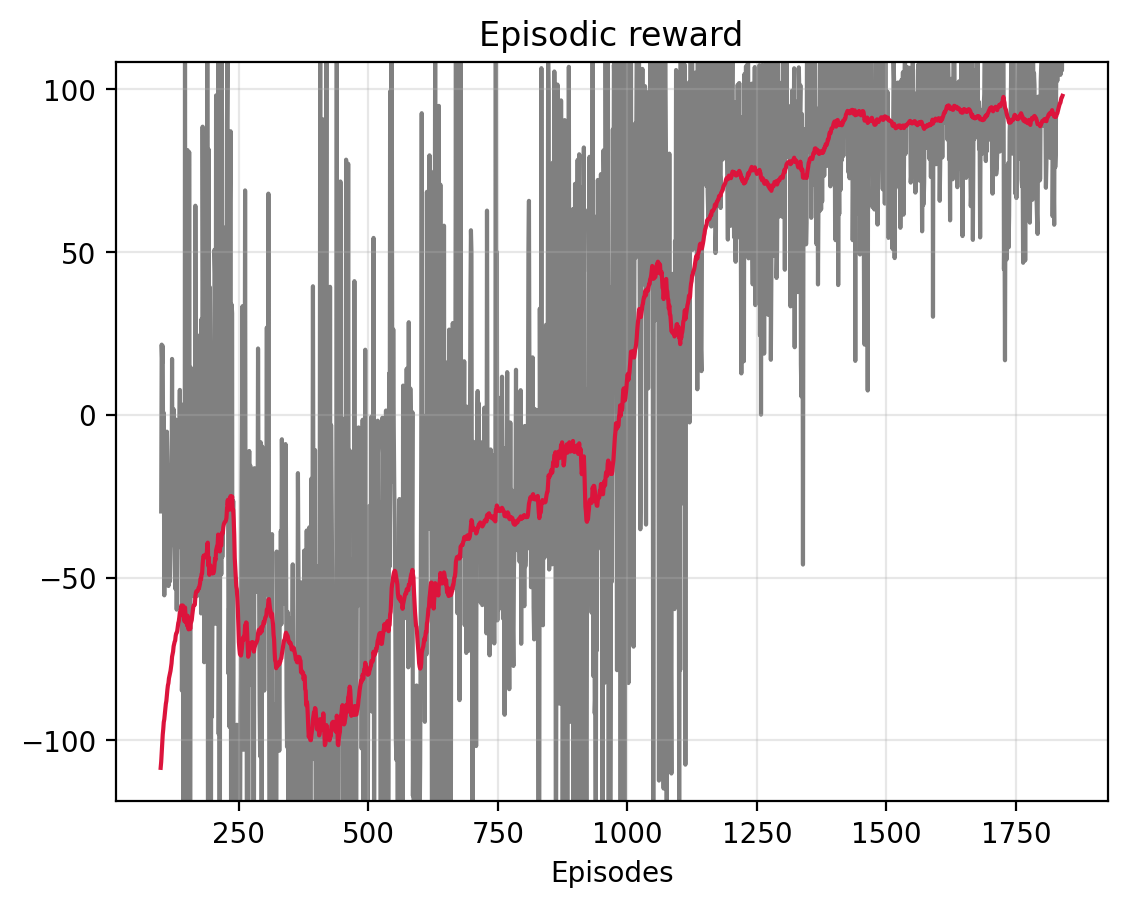

In [40]:
final_rewards.ewm(span=100, min_periods=100).mean().plot(c="crimson")
ymin, ymax = plt.ylim()
final_rewards.iloc[100:].plot(zorder=0, c="gray")
plt.ylim(ymin, ymax)
plt.title("Episodic reward")
plt.xlabel("Episodes")
plt.grid(alpha=0.3)

## Testing policy

In [17]:
np.save("weights", W)

In [18]:
n_steps = 1000
eps = 5e-4

observation, info = env.reset(seed=3141)
action = eps_greedy_choice(W, observation, eps)

observations = []
rewards = []
actions_hist = []

episode_reward = 0.0
for t in range(n_steps):
    observation, reward, terminated, truncated, info = env.step(action)
    
    action = eps_greedy_choice(W, observation, eps)

    reset = terminated or truncated
    rewards.append(reward)
    actions_hist.append(action)
    observations.append(observation)
    
    if reset:
        observation, info = env.reset()
        # action = eps_greedy_choice(W, observation, eps)
        break

observations = np.array(observations)
rewards = np.array(rewards)
print(f"\n{rewards.sum()}")


-11.373453182664221


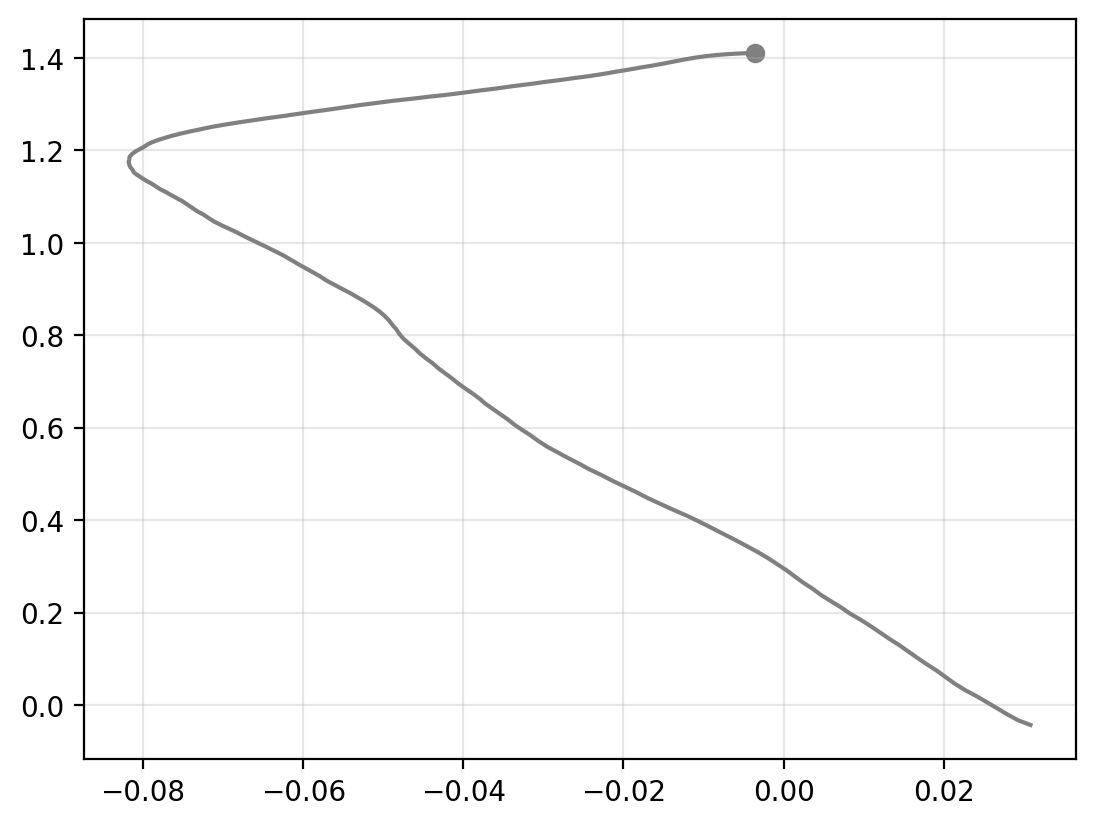

In [19]:
plt.plot(*observations[:, :2].T, c="gray")
plt.scatter(*observations[0, :2], c="gray")
plt.grid(alpha=0.3)

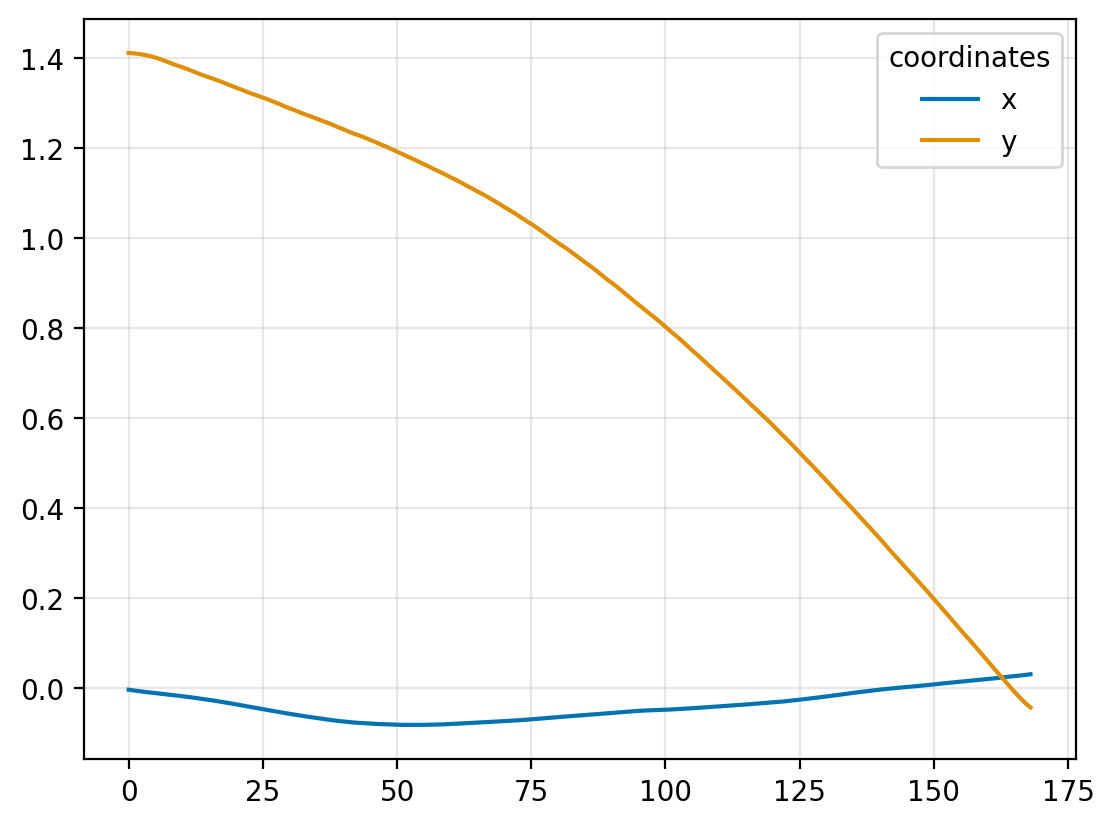

In [20]:
plt.plot(observations[:, :2], label=["x", "y"])
plt.legend(title="coordinates")
plt.grid(alpha=0.3)

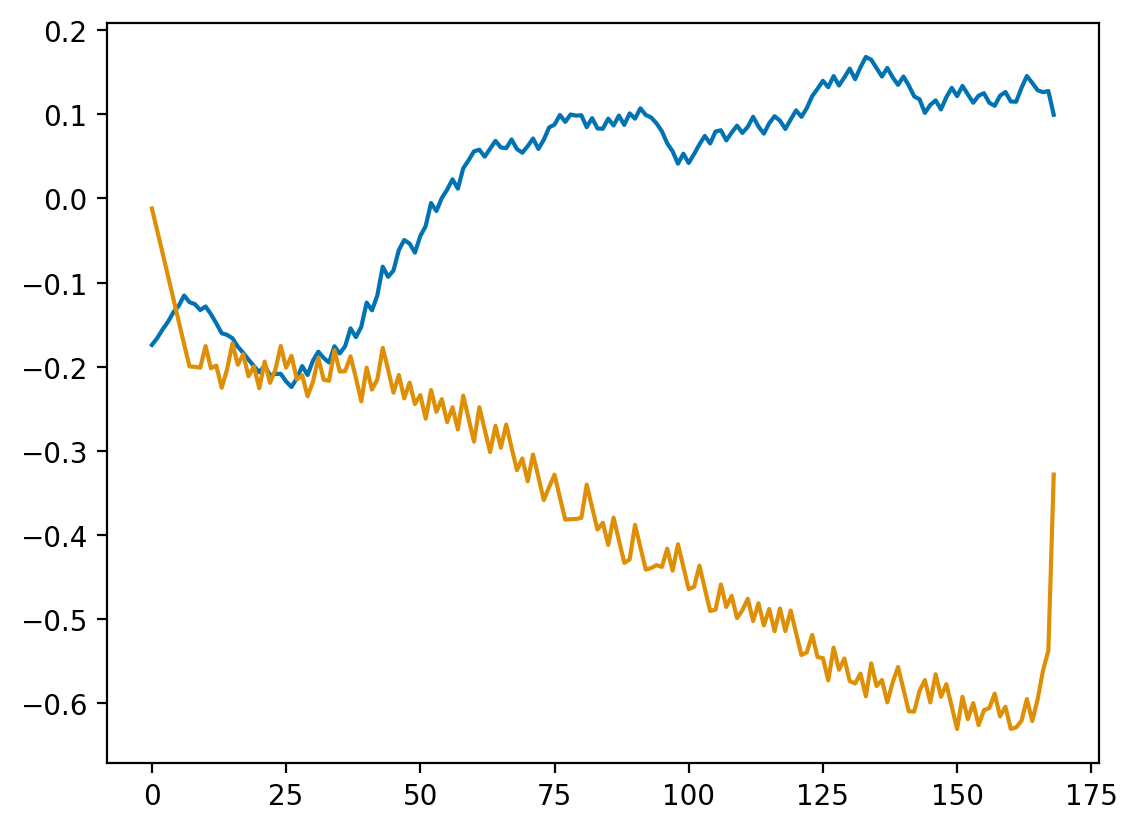

In [21]:
plt.plot(observations[:, 2:4])

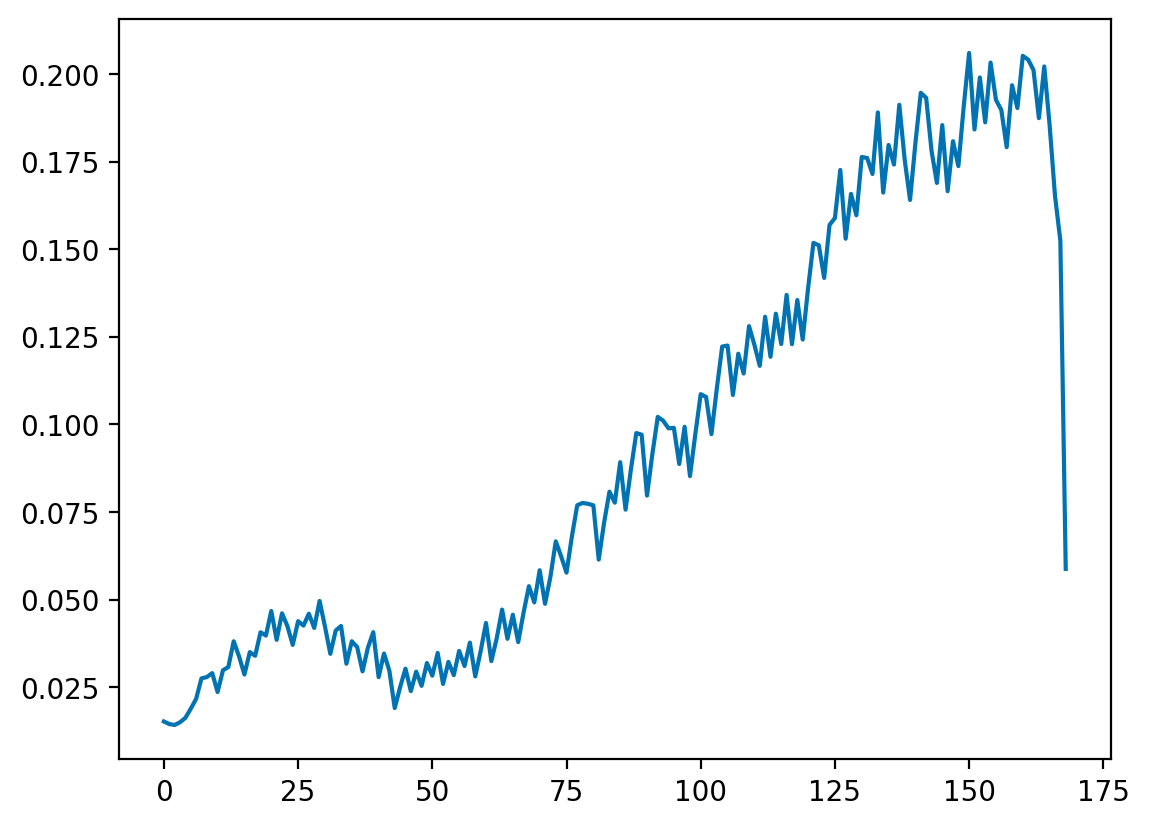

In [22]:
vel = np.power(observations[:, 2:4], 2).mean(axis=1)
plt.plot(vel)

## Multiple runs

In [31]:
colors = np.linspace(0, 1, len(checkpoint_episodes))
colors = plt.cm.viridis(colors)

-1847.6427439043275
-674.6502869805968
-140.27642381743254
-93.05003848484264
-33.273065239028895
-47.790657329862235
-6.420656730694105
16.693753259215057


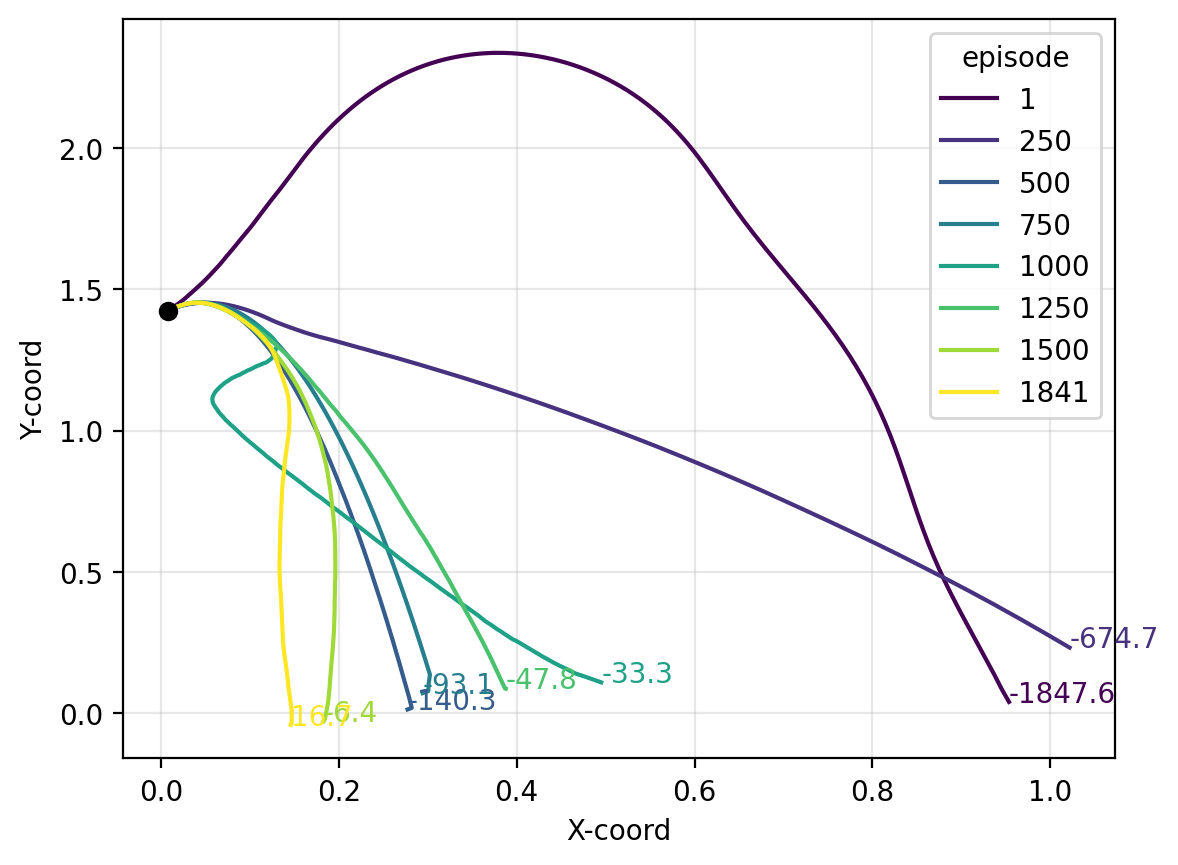

In [39]:
n_steps = 1000
eps = 5e-4

for W, episode, color in zip(checkpoint_weights, checkpoint_episodes, colors):
    observation, info = env.reset(seed=314)
    action = eps_greedy_choice(W, observation, eps)
    
    observations = []
    actions_hist = []
    
    episode_reward = 0.0
    for t in range(n_steps):
        observation, reward, terminated, truncated, info = env.step(action)
        
        action = eps_greedy_choice(W, observation, eps)
    
        reset = terminated or truncated
        actions_hist.append(action)
        observations.append(observation)
        
        episode_reward += reward
        if reset:
            observation, info = env.reset()
            # action = eps_greedy_choice(W, observation, eps)
            break
    
    observations = np.array(observations)

    plt.plot(*observations[:, :2].T, label=episode, c=color)
    
    last_x, last_y = observations[-1, :2]
    last_r = f"{episode_reward:0.1f}"
    plt.text(last_x, last_y, last_r, color=color)
    print(episode_reward)

plt.scatter(*observations[0, :2], c="black", zorder=2)
plt.xlabel("X-coord")
plt.ylabel("Y-coord")
plt.legend(title="episode")
plt.grid(alpha=0.3)